## Setting up environment

We install HuggingFace Transformers and Detectron2.

In [14]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

In [15]:
!pip install -q datasets

     |████████████████████████████████| 451 kB 7.8 MB/s 
     |████████████████████████████████| 115 kB 65.1 MB/s 
     |████████████████████████████████| 212 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 55.5 MB/s 


We also install PyTesseract:

In [13]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,968 kB/s)
debconf: unable to initia

## Getting the data

Next, we download a small subset of the RVL-CDIP dataset (which I prepared), containing 15 documents (one example per class). I omitted the "handwritten" class, because the OCR results were mediocre.


Let's look at a random training example (in this case, a resume):


In [16]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 7.8 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.3.0
    Uninstalling Pillow-9.3.0:
      Successfully uninstalled Pillow-9.3.0


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install -U pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.3.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.0.0
    Uninstalling Pillow-9.0.0:
      Successfully uninstalled Pillow-9.0.0


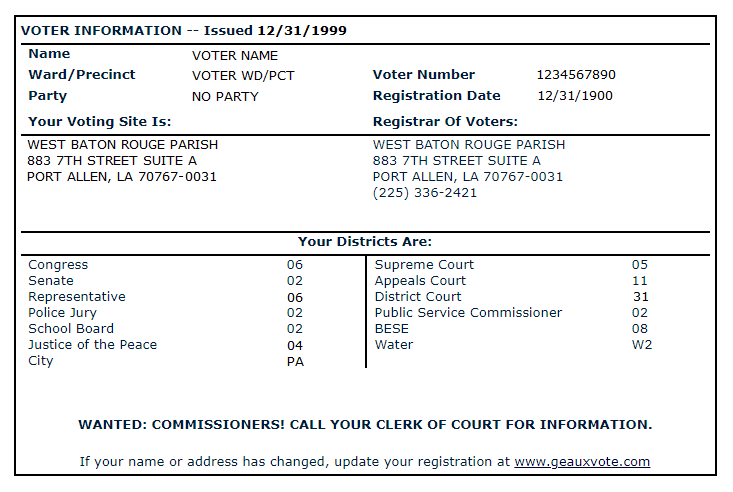

In [11]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/drive/MyDrive/data/Identity Proof/voter information card.png")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [17]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'VOTER INFORMATION -- Issued 12/31/1999 Name VOTER NAME Ward/Precinct VOTER WD/PCT Party NO PARTY Your Voting Site Is: Voter Number Registration Date 1234567890 12/31/1900 Registrar Of Voter WEST BATON ROUGE PARISH 883 7TH STREET SUITE A PORT ALLEN, LA 70767-0031 WEST BATON ROUGE PARISH 883 7TH STREET SUITE A PORT ALLEN, LA 70767-0031 (225) 336-2421 ‘Your Districts Are: ‘Congress Senate Representative Police Jury School Board 06 02 06 02 02 04 PA ‘Supreme Court Appeals Court District Court Public Service Commissioner BESE Water 05 aL a1 02 og w2 WANTED: COMMISSIONERS! CALL YOUR CLERK OF COURT FOR INFORMATION. If your name or address has changed, update your registration at www.geauxvote.com'

However, we can use `LayoutLMv2Processor` to easily prepare the data for the model. We give a document image as input to the processor, and it will create `input_ids`, `attention_mask`, `token_type_ids` and `bbox` for us. Internally, it will apply PyTesseract to get the words and bounding boxes, it will normalize the bounding boxes according to the size of the image, and it will turn everything into token-level inputs. It will also resize the document image to 224x224, as the model also requires an `image` input. Handy, isn't it?

Btw, if you prefer to use your own OCR engine, you still can. In that case, you can provide your own words and (normalized) bounding boxes to the processor.

In [18]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [19]:
encoded_inputs = processor(image, return_tensors="pt")

In [20]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 171])
bbox torch.Size([1, 171, 4])
token_type_ids torch.Size([1, 171])
attention_mask torch.Size([1, 171])
image torch.Size([1, 3, 224, 224])


Let's check whether the `input_ids` are created correctly by decoding them back to text:

In [21]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] voter information - - issued 12 / 31 / 1999 name voter name ward / precinct voter wd / pct party no party your voting site is : voter number registration date 1234567890 12 / 31 / 1900 registrar of voter west baton rouge parish 883 7th street suite a port allen, la 70767 - 0031 west baton rouge parish 883 7th street suite a port allen, la 70767 - 0031 ( 225 ) 336 - 2421 ‘ your districts are : ‘ congress senate representative police jury school board 06 02 06 02 02 04 pa ‘ supreme court appeals court district court public service commissioner bese water 05 al a1 02 og w2 wanted : commissioners! call your clerk of court for information. if your name or address has changed, update your registration at www. geauxvote. com [SEP]'

Note that it also adds the special tokens ([CLS] and [SEP]). You can also pad to a max length, truncate, etc., just like you would do with a regular tokenizer.

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label.

In [22]:
import pandas as pd
import os

dataset_path = "/content/drive/MyDrive/data"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'.DS_Store': 0,
 'Tax Return': 1,
 'Bank Statements': 2,
 'Power Of Attorney': 3,
 'Identity Proof': 4,
 'Personal Finance Statement': 5,
 'Employment Proof': 6,
 'Bussiness Proof': 7,
 'Salary Slip': 8,
 'Invoices': 9,
 'Receipts': 10,
 'Fund Raising': 11,
 'Address Proof': 12}

In [23]:
label2id = {
    'Tax Return': 0,
 'Bank Statements': 1,
 'Power Of Attorney': 2,
 'Identity Proof': 3,
 'Personal Finance Statement': 4,
 'Employment Proof': 5,
 'Bussiness Proof': 6,
 'Salary Slip': 7,
 'Invoices': 8,
 'Receipts': 9,
 'Fund Raising': 10,
 'Address Proof': 11
}

In [24]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[28:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image_file in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,/content/drive/MyDrive/data/Tax Return/tax4.jpg,Tax Return
1,/content/drive/MyDrive/data/Tax Return/tax2.jpg,Tax Return
2,/content/drive/MyDrive/data/Tax Return/tax3.jfif,Tax Return
3,/content/drive/MyDrive/data/Tax Return/tax5.jpg,Tax Return
4,/content/drive/MyDrive/data/Tax Return/tax1.png,Tax Return


In [25]:
labels = [ 'Salary Slip',
 'Fund Raising',
 'Personal Finance Statement',
 'Tax Return',
 'Reciepts',
 'Address Proof',
 'Identity Proof',
 'Power Of Attorney',
 'Invoices',
 'Bussiness Proof',
 'Bank Statement',
 'Employment Proof']

In [26]:
from datasets import Dataset 

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [27]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 62
})

In [28]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features, 
                              batched=True, batch_size=2)

  0%|          | 0/31 [00:00<?, ?ba/s]

Next, we set the format to PyTorch tensors. We also specify to put everything on the GPU (CUDA).

In [29]:
encoded_dataset.set_format(type="torch", device="cuda")

In [25]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8 MB 653 bytes/s 
     |████████████████████████████████| 24.3 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 986 kB/s 
     |████████████████████████████████| 19.1 MB 902 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 867 kB/s 
     |████████████████████████████████| 17.3 MB 46.9 MB/s 
     |████████████████████████████████| 12.8 MB 44.7 MB/s 
     |████████████████████████████████| 12.7 MB 49.1 MB/s 
     |████████████████████████████████| 11.8 MB 49.3 MB/s 
     |████████████████████████████████| 5.9 MB 46.7 MB/s 
     |████████████████████████████████| 6.6 MB 79.7 MB/s 
     |

We can create a PyTorch dataloader now:

In [30]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

In [31]:
for k in batch:
  print(k)

image
input_ids
attention_mask
token_type_ids
bbox
labels


In [32]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [34]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] 180 ae 166 wa aa explanation of transaction exc ae eetuen thes 20n10608 nnnn - aee - 22222 - 1 reduced or removed prior tax ssuessed 11112 - 555 - 85555 - 0 interest credited to your account date 03 - 01 - 2021, 1 - 26 - 2621 05 - 24 - 2621 aawount $ 4, 056. 00, ~ $ 600. 00 0. 00 wea [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [38]:
batch['labels'][0].item()

0

In [39]:
id2label[batch['labels'][0].item()]

'.DS_Store'

In [40]:
id2label

{0: '.DS_Store',
 1: 'Tax Return',
 2: 'Bank Statements',
 3: 'Power Of Attorney',
 4: 'Identity Proof',
 5: 'Personal Finance Statement',
 6: 'Employment Proof',
 7: 'Bussiness Proof',
 8: 'Salary Slip',
 9: 'Invoices',
 10: 'Receipts',
 11: 'Fund Raising',
 12: 'Address Proof'}

In [42]:
id2label = {0: 'Tax Return',
 1: 'Bank Statements',
 2: 'Power Of Attorney',
 3: 'Identity Proof',
 4: 'Personal Finance Statement',
 5: 'Employment Proof',
 6: 'Bussiness Proof',
 7: 'Salary Slip',
 8: 'Invoices',
 9: 'Receipts',
 10: 'Fund Raising',
 11: 'Address Proof'}
    


In [23]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-iun3a2w5
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-iun3a2w5
     |████████████████████████████████| 50 kB 3.7 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 151 kB 56.1 MB/s 
     |████████████████████████████████| 1.4 MB 66.5 MB/s 
     |████████████████████████████████| 549 kB 66.8 MB/s 
     |████████████████████████████████| 248 kB 56.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 843 kB 63.3 MB/s 
     |████████████████████████████████| 96 kB 7.7 MB/s 
     |████████████████████████████████| 117 kB 70.4 MB/s 
  Created whee

In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.2 MB/s 
     |████████████████████████████████| 182 kB 45.3 MB/s 
     |████████████████████████████████| 7.6 MB 8.7 MB/s 


In [6]:
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:49tcmalloc: large alloc 1147494400 bytes == 0x39900000 @  0x7ff6d7c28615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 6.8 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
     |████████████████████████████████| 849 kB 59.2 MB/s 
     |████████████████████████████████| 317.1 MB 31 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.0.0
    Uninstalling torch-1.0.0:
      Successfully uninstalled torch-1.0.0
ERROR: pip's dependency resolver does not currently 

In [6]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...


In [8]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-y6ei032z
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-y6ei032z
     |████████████████████████████████| 50 kB 4.1 MB/s 
     |████████████████████████████████| 79 kB 8.5 MB/s 
     |████████████████████████████████| 151 kB 65.7 MB/s 
     |████████████████████████████████| 1.4 MB 62.3 MB/s 
     |████████████████████████████████| 549 kB 71.0 MB/s 
     |████████████████████████████████| 248 kB 28.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 96 kB 6.9 MB/s 
     |████████████████████████████████| 843 kB 62.0 MB/s 
     |████████████████████████████████| 117 kB 62.7 MB/s 
  Created whee

## Define the model

Here we define the model, namely `LayoutLMv2ForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [43]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=len(labels))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.15.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.5.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.stem.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv2.norm.num_batches_trac

LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see here for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [44]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 23.712147533893585
Training accuracy: 9.67741870880127
Epoch: 1


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 20.065616488456726
Training accuracy: 1.612903118133545
Epoch: 2


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 19.208356857299805
Training accuracy: 12.90322494506836
Epoch: 3


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 19.094218969345093
Training accuracy: 9.67741870880127
Epoch: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 17.328394651412964
Training accuracy: 27.419353485107422
Epoch: 5


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 15.264058232307434
Training accuracy: 48.3870964050293
Epoch: 6


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 13.789855003356934
Training accuracy: 53.22580337524414
Epoch: 7


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 12.31074595451355
Training accuracy: 67.74193572998047
Epoch: 8


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 10.62469020485878
Training accuracy: 69.3548355102539
Epoch: 9


  0%|          | 0/16 [00:00<?, ?it/s]

Loss: 7.584315896034241
Training accuracy: 87.09677124023438


## Inference

To perform inference on a new document image, 3 things need to be done:

1. prepare the image for the model using `LayoutLMv2Processor`
2. forward pass through the model
3. convert the output of the model to an actual label name

Let's take the first image of the training dataset as an example.

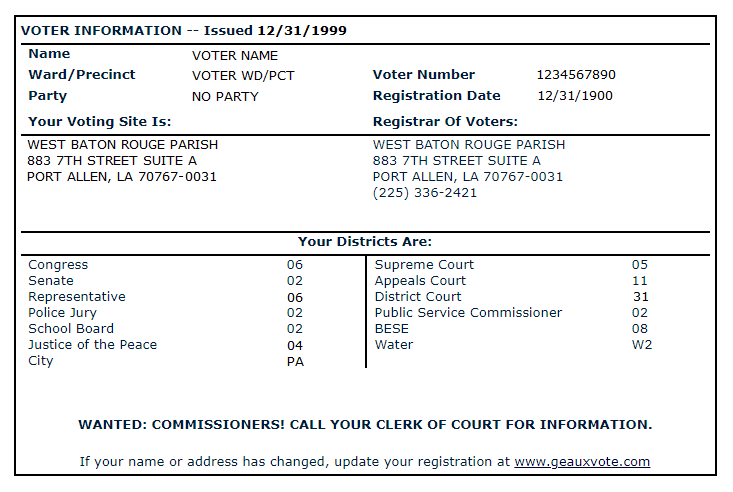

In [45]:
image

In [46]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [47]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 12])


We simply take the largest logit (i.e. `argmax` on the last dimension), and convert it back to a string using the `id2label` dictionary we created earlier.

In [48]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: Identity Proof


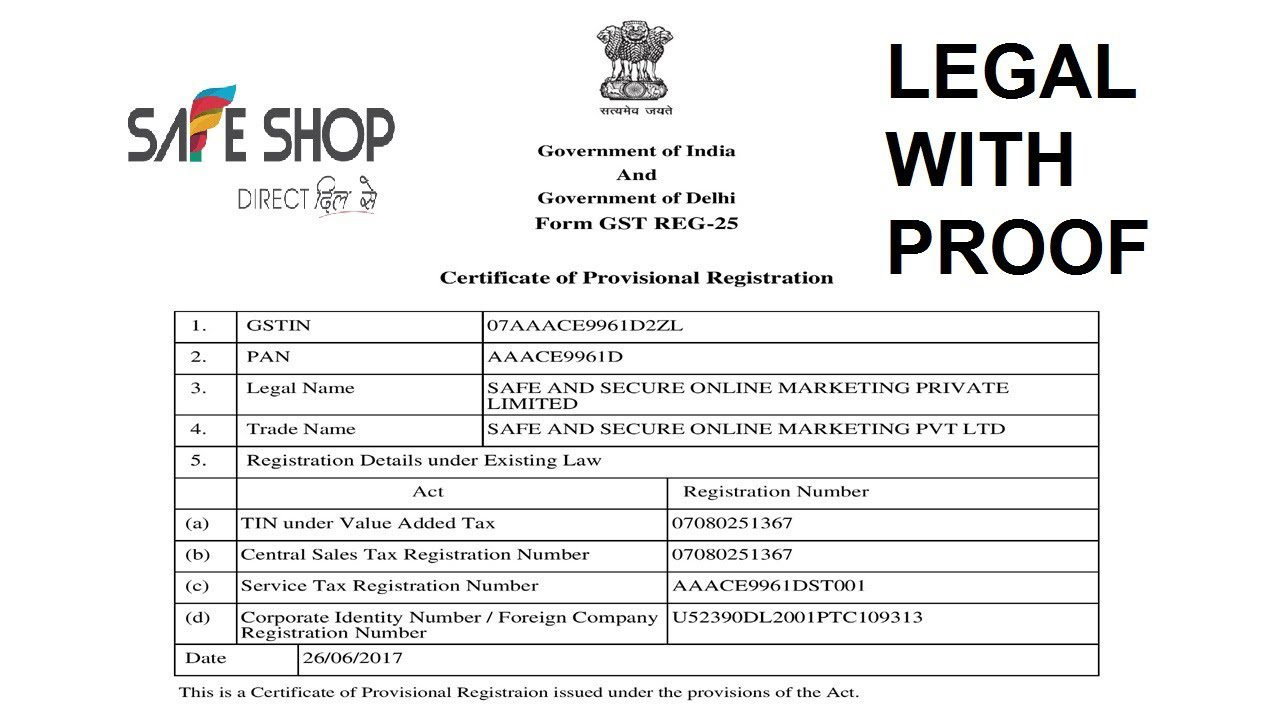

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image2 = Image.open("Downloads/invoice_14.png")
image2 = image2.convert("RGB")
image2

In [ ]:
# prepare image for the model
encoded_inputs = processor(image2, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

In [ ]:
logits = outputs.logits
print(logits.shape)

torch.Size([1, 12])


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: Bussiness Proof
